# Setup


In [1]:
import sys
import numpy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  94000      0 --:--:-- --:--:-- --:--:-- 94000
OK
51 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 51 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 22.9 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.32.0_amd64.deb ...
Unpacking gcsfuse (0.32.0) ...
Setting up gcsfuse (0.32.0) ...


In [3]:
sys.path.insert(0,'/content/drive/My Drive/COCOSegmentation')
sys.path.insert(0,'/content/drive/My Drive/COCOSegementation/cocostuffapimaster/PythonAPI')

In [4]:
%%shell
pip uninstall pycocotools
{
  cd 'drive/My Drive/COCOSegmentation/cocostuffapimaster/PythonAPI'
  python setup.py build_ext install
  
  pip install wandb
} &>/dev/null

Uninstalling pycocotools-2.0.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pycocotools-2.0.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pycocotools/*
Proceed (y/n)? y
  Successfully uninstalled pycocotools-2.0.2


In [5]:
%%bash
cd ..
cd '/usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg'
dir
mv pycocotools ..

EGG-INFO  pycocotools


In [6]:
import os
import os.path
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import random
import wandb
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from pycocotools.cocostuffhelper import cocoSegmentationToSegmentationMap
from PIL import Image
from ConvAutoencoder import architecture, Autoencoder
from train_epoch import train_epoch, evaluate, checkMemory
from train import CocoStuff, PadImages, showSegmentationGroundTruth, showSegmentationModelGenerated

In [7]:
os.getcwd()
os.chdir('/content/drive/MyDrive/COCOSegmentation')

In [8]:
!mkdir gcp_coco
!gcsfuse --implicit-dirs harry-coco-bucket gcp_coco
!dir

mkdir: cannot create directory ‘gcp_coco’: File exists
Using mount point: /content/drive/My Drive/COCOSegmentation/gcp_coco
Opening GCS connection...
Mounting file system...
File system has been successfully mounted.
checkpoint1_1.pth   ConvAutoencoder.py	__pycache__	wandb
checkpoint.pth	    dataPreprocess.py	train_epoch.py
cocostuffapimaster  gcp_coco		train.py


#Model

In [9]:
def arch(inChannels, outChannels, ch=16, pool=True):
  arch = {}
  arch['in'] = inChannels
  arch['out'] = outChannels
  arch['encoder'] = [
      (2*ch, 2*ch, pool),
      (2*ch, 2*ch, pool),
  ]

  arch['decoder'] = [             
      (2*ch, 2*ch, pool),
      (2*ch, 2*ch, pool)
  ]

  arch['inputChannels'] = ch
  arch['outputChannels'] = ch
  arch['groups'] = 1
  arch['channel_ratio'] = 1
  return arch

In [10]:
loadModel = True

torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')

num_epochs = 3
minibatch_size = 4
batch_size = 32
numClasses = 184


model = Autoencoder(arch(3, numClasses, pool=False)).cuda()
optimizer = optim.AdamW(model.parameters())

if loadModel:
  state_dict = torch.load('checkpoint1_1.pth')
  model.load_state_dict(state_dict['model'])
  optimizer.load_state_dict(state_dict['optimizer'])


lossFunction = nn.CrossEntropyLoss()
checkMemory()

Tesla V100-SXM2-16GB
Reserved GPU Memory Full: 54.20%  Total GPU Memory Full0.01%


In [11]:
def collateBatch(data):
  return PadImages(data)

val = CocoStuff(root = 'gcp_coco/images/val2017',
                        annFile = 'gcp_coco/annotations/stuff_val2017.json',
                        transform=transforms.ToTensor())

valDataLoader = DataLoader(val, batch_size=minibatch_size, collate_fn=collateBatch, num_workers=16, pin_memory=True)

'''train = CocoStuff(root = 'gcp_coco/images/train2017',
                        annFile = 'gcp_coco/annotations/stuff_train2017.json',
                        transform=transforms.ToTensor())

trainDataLoader = DataLoader(train, batch_size=minibatch_size, collate_fn=collateBatch, num_workers=16, pin_memory=True)
checkMemory()'''

Done (t=3.18s)
creating index...
index created!


"train = CocoStuff(root = 'gcp_coco/images/train2017',\n                        annFile = 'gcp_coco/annotations/stuff_train2017.json',\n                        transform=transforms.ToTensor())\n\ntrainDataLoader = DataLoader(train, batch_size=minibatch_size, collate_fn=collateBatch, num_workers=16, pin_memory=True)\ncheckMemory()"

In [12]:
wandb.init(project="COCO Image Segmentation", reinit=True)

wandb.config.adamw = {
      'lr': 0.001,
      'betas': (0.9, 0.999),
      'eps': 1e-08,
      'weight_decay': 0,
      'amsgrad': False
    }
wandb.config.data = 'COCO'
wandb.config.batch_size = batch_size
wandb.config.architecture = arch(3, 184)
wandb.watch(model)
checkMemory()

wandb: Currently logged in as: harribo (use `wandb login --relogin` to force relogin)


Reserved GPU Memory Full: 54.20%  Total GPU Memory Full0.01%


In [13]:
evaluate(model, optimizer, valDataLoader, lossFunction, folder='gcp_coco/annotations/internal/val2017', showLoss=False, showMemory=False, miniBatchSize=minibatch_size)
'''for epoch in range(num_epochs):
    #train_epoch(model, optimizer, trainDataLoader, lossFunction, showLoss=False, showMemory=False, batchSize=batch_size, miniBatchSize=minibatch_size)
    
    checkpoint = { 
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint2_1.pth')
    #wandb.save('checkpoint1_1.pth')'''

"for epoch in range(num_epochs):\n    #train_epoch(model, optimizer, trainDataLoader, lossFunction, showLoss=False, showMemory=False, batchSize=batch_size, miniBatchSize=minibatch_size)\n    \n    checkpoint = { \n    'model': model.state_dict(),\n    'optimizer': optimizer.state_dict()}\n    torch.save(checkpoint, 'checkpoint2_1.pth')\n    #wandb.save('checkpoint1_1.pth')"

Done (t=2.01s)
creating index...
index created!
{'dirt': 123, 'grass': 5953, 'road': 200, 'sand': 71884, 'sea': 2187, 'sky-other': 61308, 'snow': 2, 'tree': 17490, 'other': 85961}


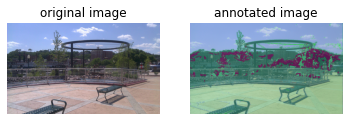

{'clouds': 34, 'dirt': 18722, 'grass': 49020, 'playingfield': 90, 'road': 1198, 'sand': 70937, 'sea': 676, 'sky-other': 21613, 'tree': 42, 'other': 142919}


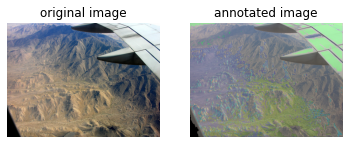

{'clouds': 9766, 'road': 12379, 'sand': 9133, 'sea': 34588, 'sky-other': 28891, 'snow': 2916, 'wall-concrete': 6051, 'other': 163084}


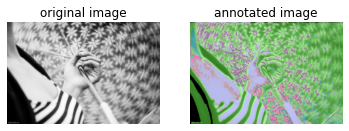

{'other': 140336}


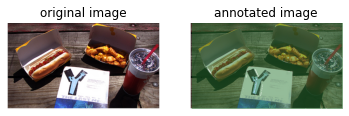

{'wall-concrete': 3663, 'other': 303347}


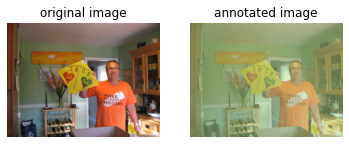

{'wall-concrete': 7957, 'other': 297047}


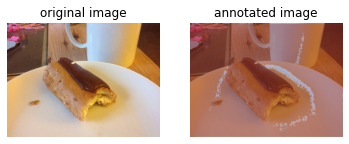

{'dirt': 11, 'grass': 2542, 'playingfield': 31880, 'road': 91, 'snow': 4, 'tree': 44, 'wall-concrete': 1, 'other': 238094}


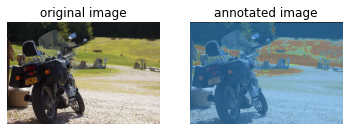

{'dirt': 16631, 'grass': 75542, 'playingfield': 45, 'road': 20, 'sand': 1, 'tree': 50309, 'other': 111635}


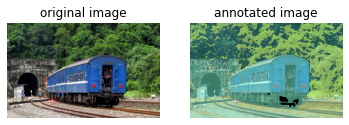

{'building-other': 411, 'dirt': 6409, 'grass': 3386, 'road': 59389, 'sand': 139, 'sky-other': 43929, 'snow': 1, 'tree': 54769, 'other': 130591}


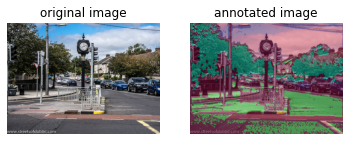

{'dirt': 384, 'grass': 152268, 'playingfield': 12550, 'sky-other': 35, 'tree': 22531, 'other': 85631}


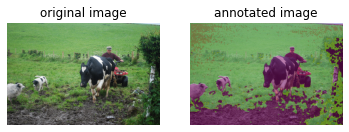

{'building-other': 1, 'road': 9562, 'sand': 505, 'sea': 9681, 'sky-other': 670, 'snow': 2295, 'wall-concrete': 2974, 'other': 281233}


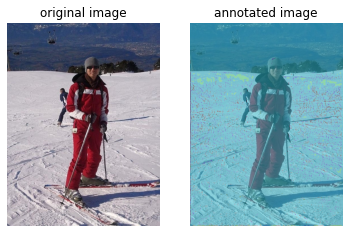

{'grass': 473, 'playingfield': 553, 'road': 38, 'sky-other': 180, 'tree': 45, 'other': 305515}


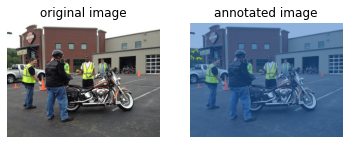

{'other': 186153}


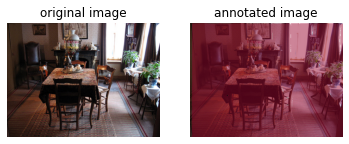

{'dirt': 32236, 'grass': 70306, 'playingfield': 2758, 'sand': 89893, 'sea': 6554, 'sky-other': 759, 'tree': 66, 'other': 70674}


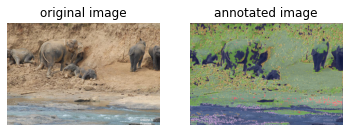

{'dirt': 9022, 'grass': 109580, 'playingfield': 1, 'sand': 2886, 'sea': 54, 'sky-other': 83518, 'tree': 23909, 'other': 42220}


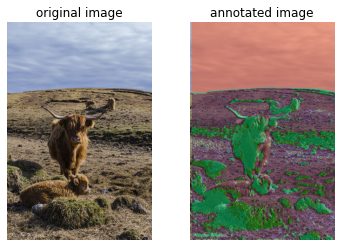

{'dirt': 1827, 'grass': 1779, 'playingfield': 3, 'road': 2790, 'sand': 60503, 'sea': 413, 'sky-other': 36, 'snow': 51, 'tree': 71, 'other': 119842}


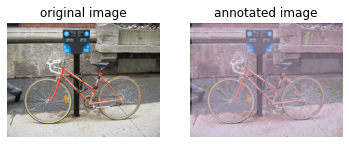

{'dirt': 9169, 'grass': 69711, 'playingfield': 4813, 'road': 27, 'sky-other': 7821, 'tree': 21958, 'other': 193580}


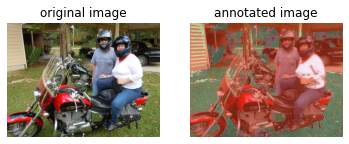

{'wall-concrete': 90577, 'wall-tile': 717, 'other': 78952}


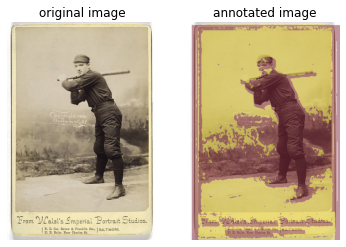

{'grass': 62, 'playingfield': 21056, 'road': 324, 'other': 285005}


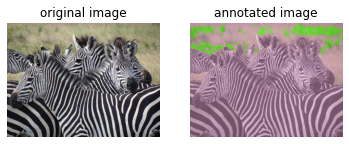

{'playingfield': 8, 'wall-concrete': 28182, 'other': 278816}


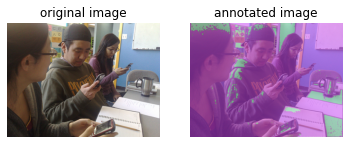

{'sky-other': 18, 'other': 178950}


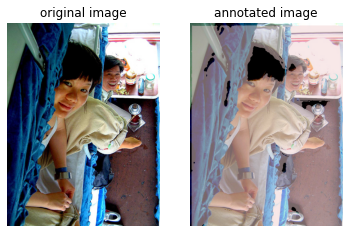

{'dirt': 878, 'grass': 52515, 'playingfield': 936, 'road': 29293, 'sand': 15865, 'sea': 641, 'sky-other': 98624, 'tree': 3892, 'other': 104470}


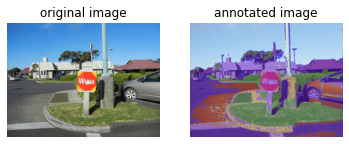

{'wall-concrete': 83228, 'other': 222300}


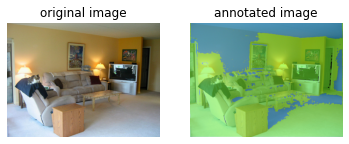

{'building-other': 473, 'dirt': 39, 'grass': 2, 'pavement': 3, 'road': 41784, 'sand': 73, 'sky-other': 4287, 'snow': 74, 'tree': 3496, 'other': 222068}


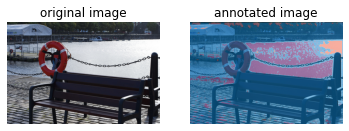

{'wall-concrete': 5801, 'other': 180499}


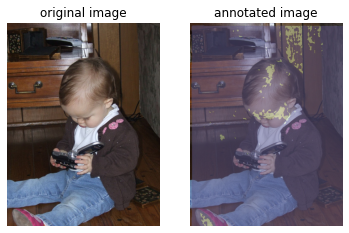

{'dirt': 2374, 'grass': 60704, 'playingfield': 3783, 'road': 1981, 'sky-other': 25613, 'tree': 19049, 'other': 193237}


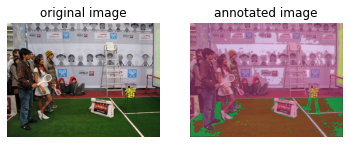

{'wall-concrete': 2269, 'other': 304321}


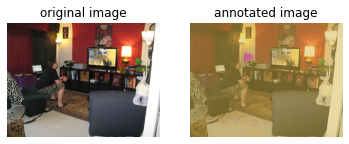

{'dirt': 51, 'grass': 114, 'playingfield': 401, 'sand': 56734, 'wall-concrete': 9253, 'other': 240394}


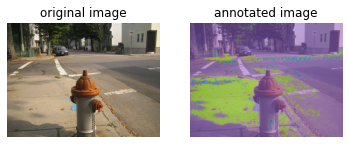

{'wall-concrete': 7795, 'other': 346455}


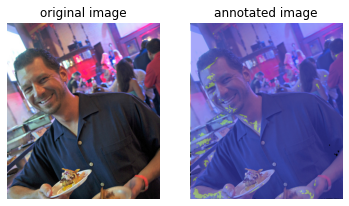

{'dirt': 21, 'grass': 108, 'playingfield': 26448, 'road': 2, 'sand': 341, 'sea': 932, 'sky-other': 4, 'wall-concrete': 26, 'other': 244742}


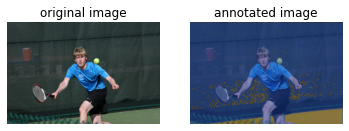

{'building-other': 32, 'dirt': 5938, 'grass': 21752, 'road': 18, 'sand': 2149, 'sea': 133, 'sky-other': 85189, 'tree': 8773, 'other': 63254}


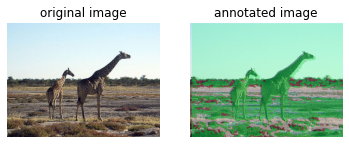

{'other': 398831}


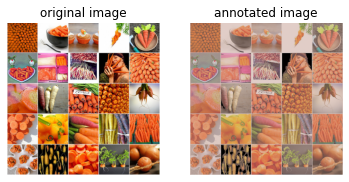

{'dirt': 543, 'grass': 159, 'playingfield': 56, 'road': 86, 'sand': 482, 'sky-other': 5, 'tree': 14867, 'other': 256516}


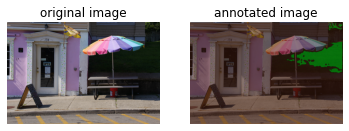

{'wall-concrete': 313, 'other': 242933}


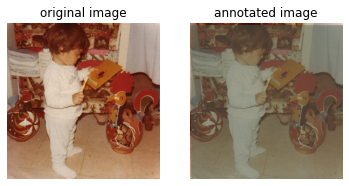

{'building-other': 773, 'clouds': 39, 'dirt': 10728, 'grass': 8111, 'road': 3094, 'sand': 508, 'sea': 43, 'sky-other': 73365, 'tree': 4092, 'other': 105037}


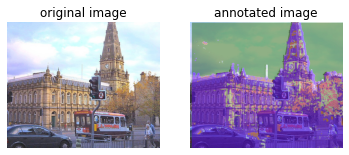

{'grass': 103, 'playingfield': 718, 'sea': 11, 'sky-other': 5722, 'snow': 280, 'wall-concrete': 69400, 'other': 196179}


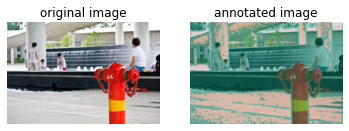

{'grass': 1141, 'road': 8, 'sky-other': 99619, 'snow': 278, 'tree': 769, 'other': 168774}


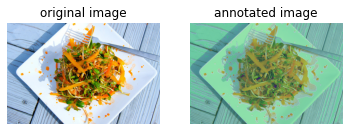

{'wall-concrete': 5777, 'other': 272004}


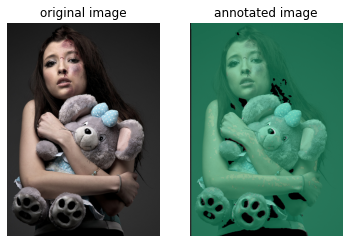

{'wall-concrete': 12395, 'other': 259464}


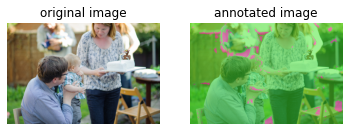

{'wall-concrete': 44, 'other': 271856}


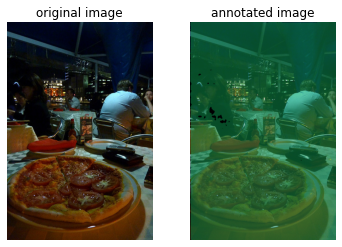

{'dirt': 179, 'grass': 913, 'playingfield': 706, 'road': 131, 'tree': 1542, 'other': 270128}


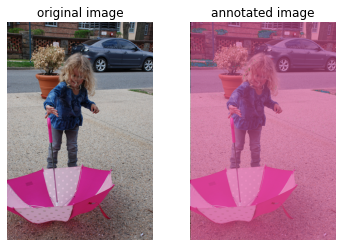

{'grass': 360, 'sand': 1652, 'sea': 17585, 'sky-other': 197778, 'snow': 79114, 'other': 10639}


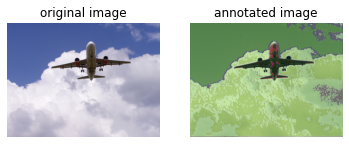

{'building-other': 3, 'dirt': 4785, 'grass': 20098, 'playingfield': 1359, 'road': 56185, 'sand': 757, 'sea': 2, 'sky-other': 6553, 'tree': 54664, 'other': 128750}


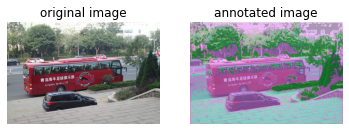

{'dirt': 3618, 'grass': 84580, 'road': 3, 'sky-other': 27894, 'tree': 49400, 'other': 104688}


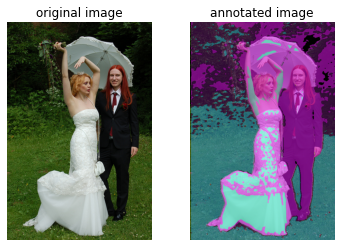

{'building-other': 27, 'grass': 115, 'road': 10255, 'sand': 5219, 'sea': 40693, 'sky-other': 125999, 'snow': 170, 'tree': 29, 'other': 90799}


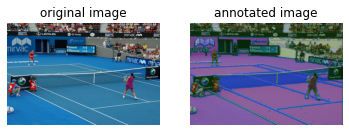

{'dirt': 101, 'grass': 1290, 'playingfield': 81552, 'other': 289789}


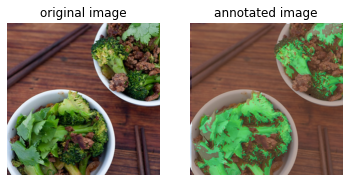

{'dirt': 16903, 'grass': 80758, 'playingfield': 4459, 'sand': 1963, 'sky-other': 335, 'tree': 1790, 'other': 55103}


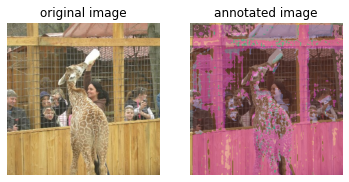

{'playingfield': 1107, 'road': 13, 'sky-other': 6, 'snow': 13, 'wall-concrete': 18777, 'other': 252442}


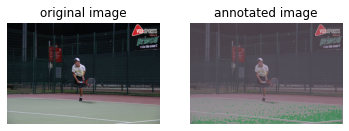

{'playingfield': 84697, 'sand': 29055, 'sea': 2521, 'sky-other': 3, 'other': 70878}


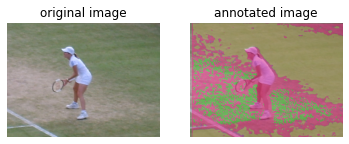

{'sand': 9548, 'sea': 21461, 'sky-other': 172237, 'snow': 690, 'other': 8537}


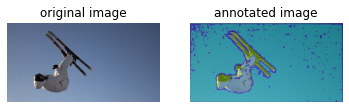

In [14]:
singleDataLoader = DataLoader(val, batch_size=1, collate_fn=collateBatch, shuffle=True, pin_memory=True)
showSegmentationModelGenerated(model, val, singleDataLoader, numToShow=50)

#Processing Results

In [17]:
from cocostuffapimaster.PythonAPI.cocostuff.internalToCocoGTDemo import internalToCocoGTDemo

internalToCocoGTDemo(dataType='val2017', dataDir='gcp_coco', stuffStartId=92, stuffEndId=182)

Streaming output truncated to the last 5000 lines.
Writing JSON annotation 2501 of 5000 (83.0s): 000000289594...
[  0  96 149 157 159 169 183]
Writing JSON annotation 2502 of 5000 (83.1s): 000000289659...
[  0 111 124 145 149 154 157 169 183]
Writing JSON annotation 2503 of 5000 (83.1s): 000000289702...
[  0 155 157 159 172 183]
Writing JSON annotation 2504 of 5000 (83.1s): 000000289741...
[  0  96 111 124 149 154 155 157 159 169 183]
Writing JSON annotation 2505 of 5000 (83.2s): 000000289938...
[  0 183]
Writing JSON annotation 2506 of 5000 (83.2s): 000000289960...
[  0 106 154 155 157 159 172 183]
Writing JSON annotation 2507 of 5000 (83.2s): 000000289992...
[  0 155 172 176 183]
Writing JSON annotation 2508 of 5000 (83.3s): 000000290081...
[  0 183]
Writing JSON annotation 2509 of 5000 (83.3s): 000000290163...
[  0 124 145 172 183]
Writing JSON annotation 2510 of 5000 (83.4s): 000000290179...
[  0 106 111 124 145 149 154 155 157 169 172 183]
Writing JSON annotation 2511 of 5000 (83.

In [9]:
from cocostuffapimaster.PythonAPI.cocostuff.cocoStuffEvalDemo import cocoStuffEvalDemo

cocoStuffEvalDemo(dataDir='gcp_coco', dataType='val2017', resType='val2017')

Done (t=3.99s)
creating index...
index created!
Loading and preparing results...


AssertionError: ignored

Streaming output truncated to the last 5000 lines.
Exporting image 1 of 5000: 000000397133
Exporting image 2 of 5000: 000000037777
Exporting image 3 of 5000: 000000252219
Exporting image 4 of 5000: 000000087038
Exporting image 5 of 5000: 000000174482
Exporting image 6 of 5000: 000000403385
Exporting image 7 of 5000: 000000006818
Exporting image 8 of 5000: 000000480985
Exporting image 9 of 5000: 000000458054
Exporting image 10 of 5000: 000000331352
Exporting image 11 of 5000: 000000296649
Exporting image 12 of 5000: 000000386912
Exporting image 13 of 5000: 000000502136
Exporting image 14 of 5000: 000000491497
Exporting image 15 of 5000: 000000184791
Exporting image 16 of 5000: 000000348881
Exporting image 17 of 5000: 000000289393
Exporting image 18 of 5000: 000000522713
Exporting image 19 of 5000: 000000181666
Exporting image 20 of 5000: 000000017627
Exporting image 21 of 5000: 000000143931
Exporting image 22 of 5000: 000000303818
Exporting image 23 of 5000: 000000463730
Exporting image

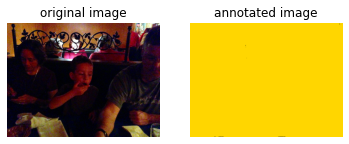

In [19]:
from cocostuffapimaster.PythonAPI.cocostuff.cocoSegmentationToPngDemo import cocoSegmentationToPngDemo

cocoSegmentationToPngDemo(dataDir='gcp_coco', dataTypeAnn='predict_val2017', dataTypeRes='val2017',exportImageLimit=1e10)

In [10]:
from cocostuffapimaster.PythonAPI.cocostuff.pngToCocoResultDemo import pngToCocoResultDem

pngToCocoResultDemo(dataDir='gcp_coco', resType='val2017')

Streaming output truncated to the last 5000 lines.
Converting png image 1 of 5000: 000000000139
Converting png image 2 of 5000: 000000000285
Converting png image 3 of 5000: 000000000632
Converting png image 4 of 5000: 000000000724
Converting png image 5 of 5000: 000000000776
Converting png image 6 of 5000: 000000000785
Converting png image 7 of 5000: 000000000802
Converting png image 8 of 5000: 000000000872
Converting png image 9 of 5000: 000000000885
Converting png image 10 of 5000: 000000001000
Converting png image 11 of 5000: 000000001268
Converting png image 12 of 5000: 000000001296
Converting png image 13 of 5000: 000000001353
Converting png image 14 of 5000: 000000001425
Converting png image 15 of 5000: 000000001490
Converting png image 16 of 5000: 000000001503
Converting png image 17 of 5000: 000000001532
Converting png image 18 of 5000: 000000001584
Converting png image 19 of 5000: 000000001675
Converting png image 20 of 5000: 000000001761
Converting png image 21 of 5000: 00000

In [9]:
from pycocotools.cocostuffeval import COCOStuffeval

annFile = 'gcp_coco/annotations/stuff_val2017.json'
resFile = 'gcp_coco/results/stuff_val2017_results.json'

# Initialize COCO ground-truth API
cocoGt = COCO(annFile)

# Initialize COCO result API
cocoRes = cocoGt.loadRes(resFile)

# Initialize the evaluation
cocoEval = COCOStuffeval(cocoGt, cocoRes)

# Run evaluation on the example images
cocoEval.evaluate()
cocoEval.summarize()


Done (t=4.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.34s)
creating index...
index created!
Evaluating stuff segmentation on 5000 images and 92 classes...
Evaluating image 1 of 5000: 139
Evaluating image 10 of 5000: 1000
Evaluating image 20 of 5000: 1761
Evaluating image 30 of 5000: 2473
Evaluating image 40 of 5000: 3661
Evaluating image 50 of 5000: 5060
Evaluating image 60 of 5000: 6213
Evaluating image 70 of 5000: 7088
Evaluating image 80 of 5000: 7818
Evaluating image 90 of 5000: 8762
Evaluating image 100 of 5000: 9891
Evaluating image 110 of 5000: 11122
Evaluating image 120 of 5000: 12280
Evaluating image 130 of 5000: 13348
Evaluating image 140 of 5000: 14380
Evaluating image 150 of 5000: 15338
Evaluating image 160 of 5000: 16228
Evaluating image 170 of 5000: 17178
Evaluating image 180 of 5000: 18150
Evaluating image 190 of 5000: 19042
Evaluating image 200 of 5000: 20247
Evaluating image 210 of 5000: 21879
Evaluating image 220 of 5000: 22892
Eva

(array([0.00334446, 0.09467357, 0.01086957, 0.3076907 , 0.01923067,
        0.09467357, 0.0625    , 0.3076907 ]),
 {'ious': array([      nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan,       nan,       nan,
               nan,       nan,       nan,       nan, 

In [17]:
'''checkpoint = { 
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')
wandb.save('checkpoint.pth')'''

"checkpoint = { \n    'model': model.state_dict(),\n    'optimizer': optimizer.state_dict()}\ntorch.save(checkpoint, 'checkpoint.pth')\nwandb.save('checkpoint.pth')"

In [18]:
'''cocoTrain = COCO(annotation_file='cocostuffapimaster/annotations/stuff_train2017.json')
ids = cocoTrain.getImgIds()
ids = ids[110000:]
print(len(ids))

cocoTrain.download(tarDir='cocostuffapimaster/images/train2017', imgIds=ids)'''

"cocoTrain = COCO(annotation_file='cocostuffapimaster/annotations/stuff_train2017.json')\nids = cocoTrain.getImgIds()\nids = ids[110000:]\nprint(len(ids))\n\ncocoTrain.download(tarDir='cocostuffapimaster/images/train2017', imgIds=ids)"

In [19]:
!gsutil du gs://harry-coco-bucket/annotations/internal/val2017 | wc -l

5002
